<a href="https://colab.research.google.com/github/eerga/CapstoneMLZoomcamp/blob/main/Food_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training EfficientNetB0 model

## Get the data

In [1]:
import kagglehub
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img

# import the EffifientNet model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# Download to cache (default behavior)
path = kagglehub.dataset_download("erika7/food-101-small-10-categories-trainvaltest-split")

# Copy to your desired location
target_path = "/content/food-101"
shutil.copytree(path, target_path)

print(f"Dataset copied to: {target_path}")

Using Colab cache for faster access to the 'food-101-small-10-categories-trainvaltest-split' dataset.
Dataset copied to: /content/food-101


In [3]:
!rm -rf /root/.cache/kagglehub

In [4]:
def count_images(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        # Count common image formats
        images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        total += len(images)
    return total

In [5]:
# Count images in the clothing dataset
total_images = count_images('food-101')
print(f"Total images: {total_images}")

Total images: 3000


In [6]:
train_images = count_images('food-101/train')
print(f"Train images %: {train_images/total_images*100}")

Train images %: 80.0


In [7]:
validation_images = count_images('food-101/validation')
print(f"Total images: {validation_images/total_images*100}")

Total images: 10.0


In [8]:
test_images = count_images('food-101/test')
print(f"Total images: {test_images/total_images*100}")

Total images: 10.0


So, the split is 80% for training, 10% for validation and 10% for testing

In [9]:
dataset_path = 'food-101'

# Collect data for all categories across all splits
category_totals = {}
split_totals = {}
grand_total = 0

splits = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

for split in splits:
    split_path = os.path.join(dataset_path, split)
    split_total = 0

    if os.path.exists(split_path):
        categories = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

        for category in categories:
            category_path = os.path.join(split_path, category)
            image_files = [f for f in os.listdir(category_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
            count = len(image_files)

            # Add to category total
            if category not in category_totals:
                category_totals[category] = {}
            category_totals[category][split] = count

            split_total += count

        split_totals[split] = split_total
        grand_total += split_total

# Display summary
print("SUMMARY BY CATEGORY:")
print("=" * 60)
print(f"{'Category':<15} {'Train':<8} {'Test':<8} {'Val':<8} {'Total':<8}")
print("-" * 60)

for category in sorted(category_totals.keys()):
    train_count = category_totals[category].get('train', 0)
    test_count = category_totals[category].get('test', 0)
    val_count = category_totals[category].get('validation', 0)
    total_count = train_count + test_count + val_count

    print(f"{category.replace('_', ' ').title():<15} {train_count:<8} {test_count:<8} {val_count:<8} {total_count:<8}")

print("-" * 60)
print(f"{'TOTALS':<15} {split_totals.get('train', 0):<8} {split_totals.get('test', 0):<8} {split_totals.get('validation', 0):<8} {grand_total:<8}")

SUMMARY BY CATEGORY:
Category        Train    Test     Val      Total   
------------------------------------------------------------
Chicken Curry   240      30       30       300     
Chocolate Cake  240      30       30       300     
Fish And Chips  240      30       30       300     
Hamburger       240      30       30       300     
Ice Cream       240      30       30       300     
Pad Thai        240      30       30       300     
Pizza           240      30       30       300     
Ramen           240      30       30       300     
Sushi           240      30       30       300     
Tacos           240      30       30       300     
------------------------------------------------------------
TOTALS          2400     300      300      3000    


## Tensorflow and Keras

In [10]:
path = './food-101/train/hamburger'
name = '1010136.jpg'
fullname = f'{path}/{name}'
img1 = load_img(fullname)
print(f"Image size: {img1.size}")  # (width, height)

Image size: (512, 384)


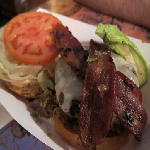

In [11]:
img = load_img(fullname, target_size=(150,150)); img

In [12]:
x = np.array(img)

In [13]:
x.shape

(150, 150, 3)

## Using Pre-trained CNN - [Keras Models](https://keras.io/api/applications/)

In [14]:
# create the model
model = EfficientNetB0(weights='imagenet', input_shape=(224,224,3))


21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
X = np.array([x])

In [16]:
X = preprocess_input(X)

In [17]:
X.shape

(1, 150, 150, 3)

## Transfer Learning

In [18]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(150,150),
      batch_size=32
      )

Found 2400 images belonging to 10 classes.


In [19]:
# classes of the traiing data
train_ds.class_indices

{'chicken_curry': 0,
 'chocolate_cake': 1,
 'fish_and_chips': 2,
 'hamburger': 3,
 'ice_cream': 4,
 'pad_thai': 5,
 'pizza': 6,
 'ramen': 7,
 'sushi': 8,
 'tacos': 9}

In [20]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(150,150),
      batch_size=32,
      shuffle=False
      )

Found 300 images belonging to 10 classes.


## Train the model

In [21]:
base_model=EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
# making no changes to the convolutional layers
base_model.trainable=False

## Creating a new top (dense layers)
inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )


In [23]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnet_v0{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [24]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6712 - loss: 1.0227

75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 301ms/step - accuracy: 0.6725 - loss: 1.0190 - val_accuracy: 0.8300 - val_loss: 0.5249
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9100 - loss: 0.2639

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9100 - loss: 0.2640 - val_accuracy: 0.8333 - val_loss: 0.5367
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9617 - loss: 0.1418 - val_accuracy: 0.8233 - val_loss: 0.5925
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9682 - loss: 0.1122 - val_accuracy: 0.8333 - val_loss: 0.6053
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9807 - loss: 0.0872 - val_accuracy: 0.8333 - val_loss: 0.6199
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9833 - loss: 0.0653

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9833 - loss: 0.0654 - val_accuracy: 0.8400 - val_loss: 0.6465
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9918 - loss: 0.0511 - val_accuracy: 0.8267 - val_loss: 0.6593
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9907 - loss: 0.0446

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9907 - loss: 0.0446 - val_accuracy: 0.8533 - val_loss: 0.6351
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9908 - loss: 0.0375 - val_accuracy: 0.8533 - val_loss: 0.6352
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9964 - loss: 0.0268

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9963 - loss: 0.0269 - val_accuracy: 0.8600 - val_loss: 0.6698


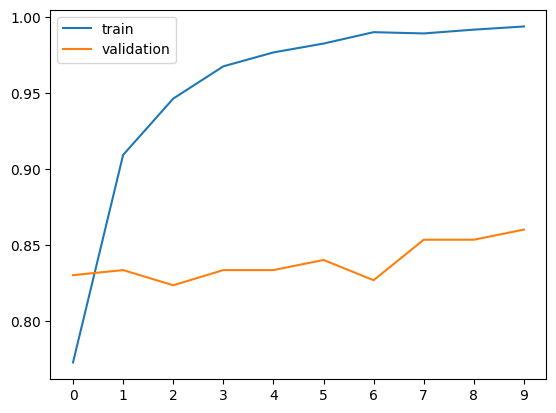

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xticks(np.arange(10))
plt.legend()

The highest validation accuracy is 0.860. Let's see if adjusting learning rate will help improve the situation.

In [26]:
!mkdir images2/

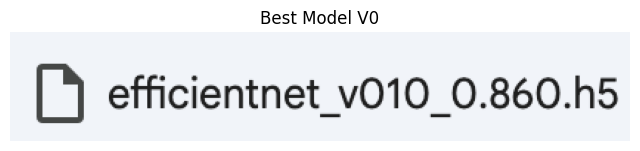

In [27]:
image_path = "./images2/best_model_v0.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V0")
plt.show()

## Adjusting Learning Rate

In [28]:
def make_model(learning_rate=0.01):
  base_model=EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  outputs = keras.layers.Dense(10)(vectors)
  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnet_v1{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [30]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])
  scores[lr]=history.history

  print()
  print()

0.0001
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2084 - loss: 2.2036

75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.2093 - loss: 2.2022 - val_accuracy: 0.4333 - val_loss: 1.8970
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4808 - loss: 1.8177

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4814 - loss: 1.8168 - val_accuracy: 0.5700 - val_loss: 1.5969
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5912 - loss: 1.5646

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5918 - loss: 1.5637 - val_accuracy: 0.6867 - val_loss: 1.3762
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6883 - loss: 1.3343

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.6885 - loss: 1.3338 - val_accuracy: 0.7333 - val_loss: 1.2123
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7415 - loss: 1.1716

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7415 - loss: 1.1713 - val_accuracy: 0.7567 - val_loss: 1.0897
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7667 - loss: 1.0490

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.7667 - loss: 1.0489 - val_accuracy: 0.7700 - val_loss: 0.9943
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7884 - loss: 0.9555 - val_accuracy: 0.7700 - val_loss: 0.9211
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7937 - loss: 0.8941

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.7938 - loss: 0.8938 - val_accuracy: 0.7833 - val_loss: 0.8611
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8095 - loss: 0.8259

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8094 - loss: 0.8258 - val_accuracy: 0.7900 - val_loss: 0.8133
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8169 - loss: 0.7720

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8169 - loss: 0.7720 - val_accuracy: 0.7967 - val_loss: 0.7723


0.001
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - accuracy: 0.4221 - loss: 1.7602 - val_accuracy: 0.7967 - val_loss: 0.7649
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8370 - loss: 0.6614

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8369 - loss: 0.6610 - val_accuracy: 0.8133 - val_loss: 0.5875
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8676 - loss: 0.5072

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.8676 - loss: 0.5070 - val_accuracy: 0.8300 - val_loss: 0.5241
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8686 - loss: 0.4438

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8688 - loss: 0.4434 - val_accuracy: 0.8433 - val_loss: 0.4882
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8931 - loss: 0.3601

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8931 - loss: 0.3602 - val_accuracy: 0.8533 - val_loss: 0.4702
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9073 - loss: 0.3340 - val_accuracy: 0.8533 - val_loss: 0.4582
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9202 - loss: 0.2926 - val_accuracy: 0.8467 - val_loss: 0.4608
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9235 - loss: 0.2719 - val_accuracy: 0.8533 - val_loss: 0.4552
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9371 - loss: 0.2510 - val_accuracy: 0.8467 - val_loss: 0.4486
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9585 - loss: 0.2153

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9585 - loss: 0.2153 - val_accuracy: 0.8600 - val_loss: 0.4444


0.01
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 218ms/step - accuracy: 0.6528 - loss: 1.0261 - val_accuracy: 0.8400 - val_loss: 0.5431
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8985 - loss: 0.3089 - val_accuracy: 0.8467 - val_loss: 0.5496
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9439 - loss: 0.1737 - val_accuracy: 0.8400 - val_loss: 0.5229
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9733 - loss: 0.1025 - val_accuracy: 0.8433 - val_loss: 0.4989
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9761 - loss: 0.0773 - val_accuracy: 0.8400 - val_loss: 0.5714
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9841 - loss: 0.0611 - val_accuracy: 0.8267 - val_loss: 0.6644
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9829 - loss: 0.0619 - val_accuracy: 0.8267 - val

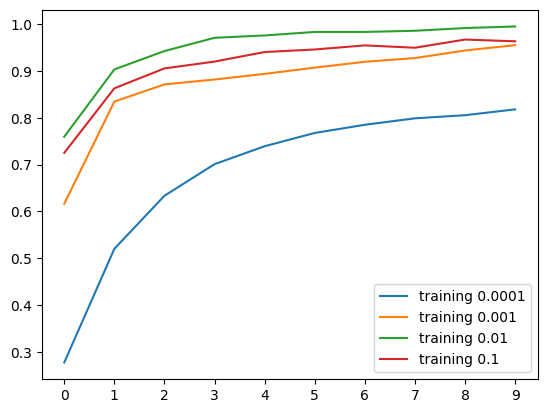

In [31]:
# training lr
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label=f'training {lr}')
plt.xticks(np.arange(10))
plt.legend()

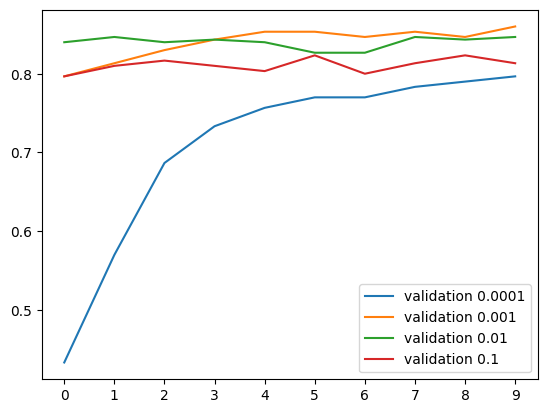

In [32]:
# validation lr
for lr, hist in scores.items():
  plt.plot(hist['val_accuracy'], label=f'validation {lr}')
plt.xticks(np.arange(10))
plt.legend()

We are going to drop learning rate 0.0001 and 0.1 because the parameter yielded the lowest validation accuracy results

In [33]:
del scores [0.0001]
del scores [0.1]

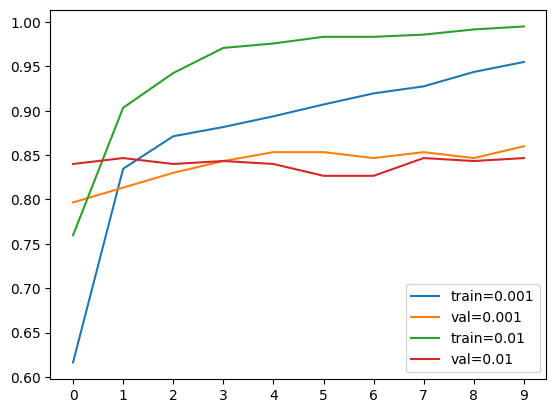

In [34]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

Since the gap between train and validation curves is smaller for lr = 0.001 than for lr = 0.01, we are choosing the learning rate to be 0.001.

Further examining learning rates, both training and validation accuracy scores are the lowest for learning rate of 0.1.

In [35]:
del scores[0.01]

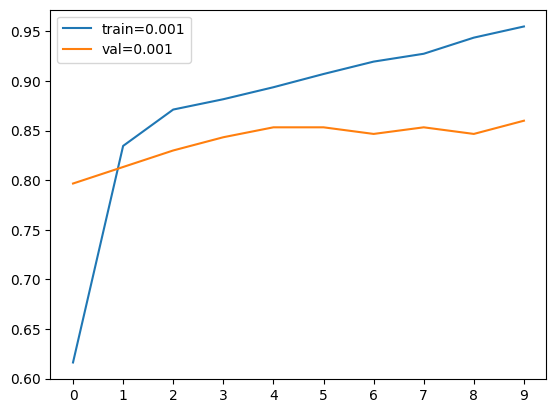

In [36]:
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

You can also notice that the best performing model so far has had the learning rate of 0.001. The best model for the first version had the
validation accuracy of 0.860.

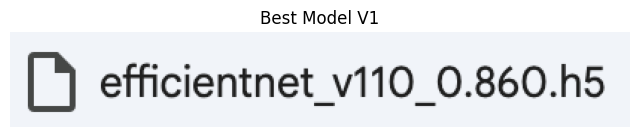

In [37]:
image_path = "./images2/best_model_v1.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V1")
plt.show()

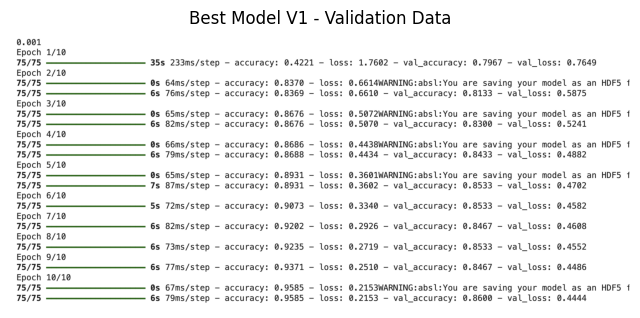

In [38]:
image_path = "./images2/best_model_v1_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V1 - Validation Data")
plt.show()

You can see that the 10th epoch is the one that was saved as the best performer.

## Checkpointing - saving the best performing models

At this point, we are simply going to run the best performing model again.

In [39]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnet_v2{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [40]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint])


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4883 - loss: 1.6696

75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.4906 - loss: 1.6640 - val_accuracy: 0.8233 - val_loss: 0.7044
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8242 - loss: 0.6644

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8242 - loss: 0.6638 - val_accuracy: 0.8367 - val_loss: 0.5499
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8743 - loss: 0.4757

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.8743 - loss: 0.4758 - val_accuracy: 0.8467 - val_loss: 0.4980
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8844 - loss: 0.4086 - val_accuracy: 0.8433 - val_loss: 0.4709
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.8940 - loss: 0.3467 - val_accuracy: 0.8467 - val_loss: 0.4575
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9227 - loss: 0.3004

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9226 - loss: 0.3007 - val_accuracy: 0.8567 - val_loss: 0.4355
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9194 - loss: 0.2743 - val_accuracy: 0.8567 - val_loss: 0.4366
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9355 - loss: 0.2586

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9355 - loss: 0.2587 - val_accuracy: 0.8600 - val_loss: 0.4290
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9457 - loss: 0.2378

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9457 - loss: 0.2378 - val_accuracy: 0.8633 - val_loss: 0.4232
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9472 - loss: 0.2126 - val_accuracy: 0.8500 - val_loss: 0.4274


The best model for the second version had the
validation accuracy of 0.863.

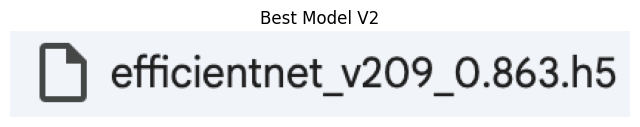

In [41]:
image_path = "./images2/best_model_v2.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V2")
plt.show()

## Adding more layers

Let's test to see if adding more dense layers will improve the model performance.

In [42]:
def make_model_more_layers(learning_rate=0.001, size_inner=100):
  base_model=EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  outputs = keras.layers.Dense(10)(inner)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [43]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnet_v3{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [44]:
learning_rate = 0.001

scores_inner_layer = {}

for size in [10, 100, 1000]:
  print(size)
  model = make_model_more_layers(learning_rate=learning_rate, size_inner=size)
  history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[checkpoint])
  scores_inner_layer[size]=history.history

  print()
  print()

10
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2959 - loss: 2.0364

75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.2976 - loss: 2.0328 - val_accuracy: 0.6433 - val_loss: 1.2437
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6961 - loss: 1.0908

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.6968 - loss: 1.0891 - val_accuracy: 0.8000 - val_loss: 0.7189
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8282 - loss: 0.6685

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8283 - loss: 0.6677 - val_accuracy: 0.8433 - val_loss: 0.5587
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8673 - loss: 0.4754

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8672 - loss: 0.4754 - val_accuracy: 0.8733 - val_loss: 0.4932
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8816 - loss: 0.4226 - val_accuracy: 0.8633 - val_loss: 0.4738
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9106 - loss: 0.3372 - val_accuracy: 0.8733 - val_loss: 0.4518
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9214 - loss: 0.3039

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9214 - loss: 0.3038 - val_accuracy: 0.8767 - val_loss: 0.4475
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9227 - loss: 0.2643 - val_accuracy: 0.8633 - val_loss: 0.4442
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9332 - loss: 0.2452 - val_accuracy: 0.8733 - val_loss: 0.4446
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9452 - loss: 0.2122 - val_accuracy: 0.8700 - val_loss: 0.4412
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9518 - loss: 0.1906 - val_accuracy: 0.8667 - val_loss: 0.4475
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9600 - loss: 0.1769 - val_accuracy: 0.8700 - val_loss: 0.4430
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9594 - loss: 0.1598 - val_accuracy: 0.8633 - val_loss: 0.4533
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9760 - loss: 0.1273 - val_accuracy: 0.8700 - val_lo

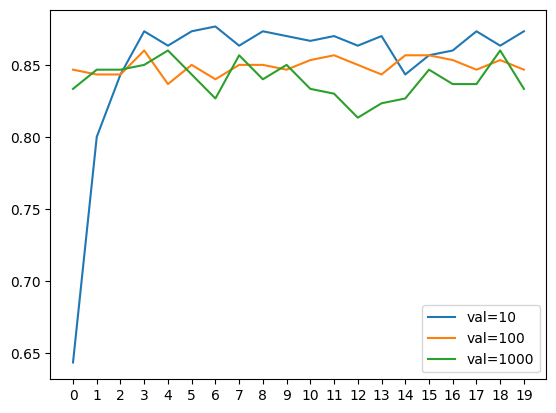

In [46]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for size, hist in scores_inner_layer.items():
  #plt.plot(hist['accuracy'], label='train=%s' % size)
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(20))
plt.legend()

The 1000 option for the dense layers was consistently underperforming, so we are going to remove it.

In [47]:
del scores_inner_layer[1000]

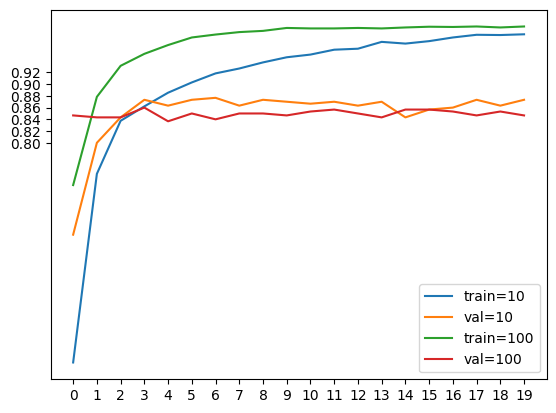

In [48]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for size, hist in scores_inner_layer.items():
  plt.plot(hist['accuracy'], label='train=%s' % size)
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(20))
plt.yticks([0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92])
plt.legend()

The gap between training and validation scores for inner layer of 10 is a bit smaller than for 100, but again, I want to experiment with droprate and see how it goes.

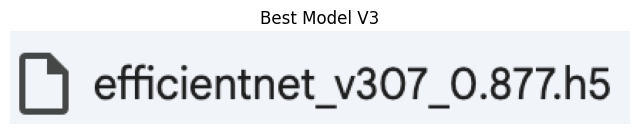

In [49]:
image_path = "./images2/best_model_v3.png"
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V3")
plt.show()

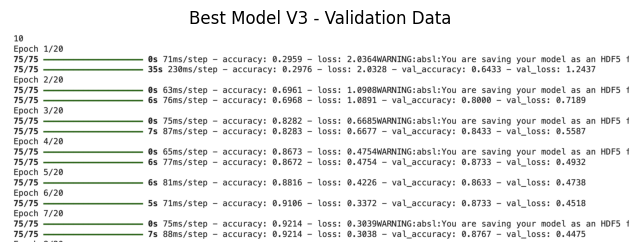

In [50]:
image_path = "./images2/best_model_v3_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V3 - Validation Data")
plt.show()

You can see that the 7th epoch is the one that was saved as the best performer for the 10 layers. Let's see if regularization and dropout will help with preventing overfitting the model.

## Regularization and Dropout

In [51]:
def make_model_more_layers_and_drop(learning_rate=0.001, size_inner=100, droprate=0.2):
  base_model=EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [52]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnet_v4{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [53]:
learning_rate = 0.001
size = 100
scores_droprate = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
  print(droprate)
  model = make_model_more_layers_and_drop(learning_rate=learning_rate, size_inner=size, droprate=droprate)
  history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])
  scores_droprate[droprate]=history.history

  print()
  print()

0.0
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5686 - loss: 1.3940

75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.5705 - loss: 1.3879 - val_accuracy: 0.8333 - val_loss: 0.5044
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8811 - loss: 0.3897

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8811 - loss: 0.3895 - val_accuracy: 0.8533 - val_loss: 0.4586
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9384 - loss: 0.2373

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9383 - loss: 0.2375 - val_accuracy: 0.8700 - val_loss: 0.4493
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9624 - loss: 0.1673 - val_accuracy: 0.8567 - val_loss: 0.4607
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9631 - loss: 0.1354 - val_accuracy: 0.8533 - val_loss: 0.4740
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9818 - loss: 0.0957 - val_accuracy: 0.8467 - val_loss: 0.4932
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9840 - loss: 0.0829 - val_accuracy: 0.8333 - val_loss: 0.5181
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9933 - loss: 0.0585 - val_accuracy: 0.8500 - val_loss: 0.5322
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9880 - loss: 0.0577 - val_accuracy: 0.8533 - val_loss: 0.5218
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9934 - loss: 0.0427 - val_accuracy: 0.8467 - val_loss: 0

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9376 - loss: 0.2021 - val_accuracy: 0.8733 - val_loss: 0.3932
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9448 - loss: 0.1898 - val_accuracy: 0.8633 - val_loss: 0.4148
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9461 - loss: 0.1683

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9461 - loss: 0.1684 - val_accuracy: 0.8800 - val_loss: 0.3991
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9582 - loss: 0.1472 - val_accuracy: 0.8733 - val_loss: 0.3935
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9644 - loss: 0.1373 - val_accuracy: 0.8500 - val_loss: 0.4232
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9608 - loss: 0.1506 - val_accuracy: 0.8600 - val_loss: 0.4399
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9685 - loss: 0.1222 - val_accuracy: 0.8533 - val_loss: 0.4353
Epoch 16/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9634 - loss: 0.1183 - val_accuracy: 0.8667 - val_loss: 0.4415
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9668 - loss: 0.1095 - val_accuracy: 0.8633 - val_loss: 0.4543
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9814 - loss: 0.0823 - val_accuracy: 0.8567 - val_l

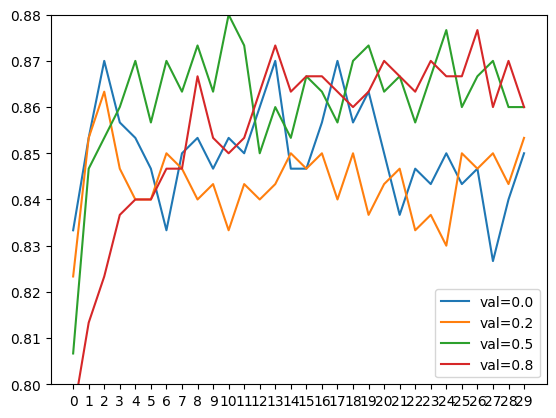

In [54]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for droprate, hist in scores_droprate.items():
  #plt.plot(hist['accuracy'], label='train=%s' % droprate)
  plt.plot(hist['val_accuracy'], label='val=%s' % droprate)
plt.xticks(np.arange(30))
plt.ylim(0.80, 0.88)
plt.legend()

This graph looks like something I would not expect. Let's see what's going on.

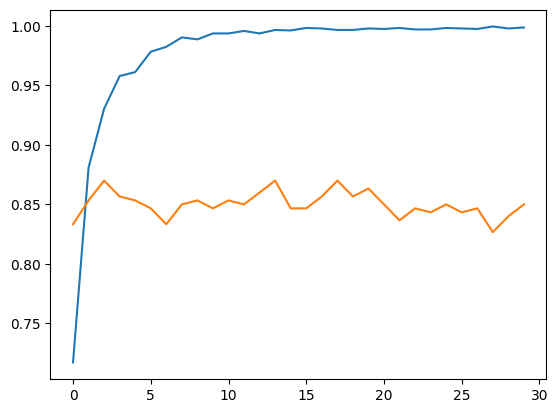

In [55]:
hist = scores_droprate[0.0]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

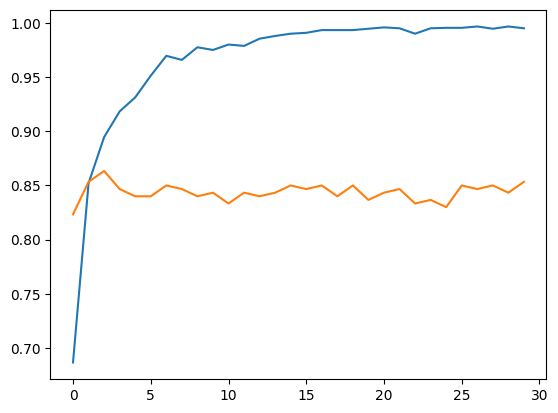

In [56]:
hist = scores_droprate[0.2]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

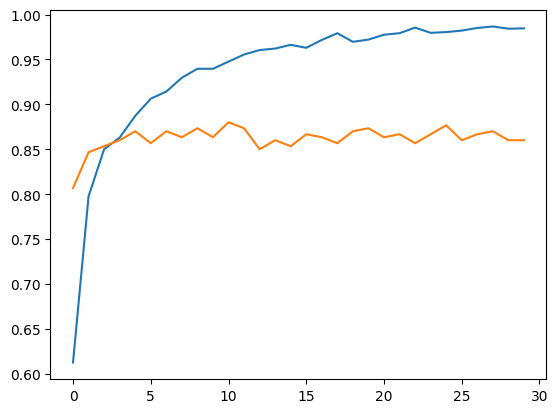

In [57]:
hist = scores_droprate[0.5]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

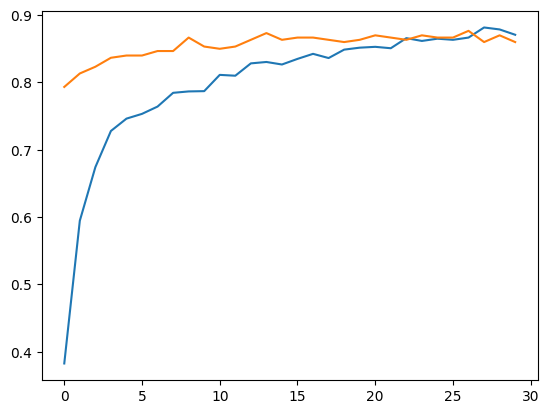

In [58]:
hist = scores_droprate[0.8]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

Conclusion: for 0.8, the validation scores are much higher than for training scores, meaning that my model underfitted severely. For 0.5, the validation scores oscillate around 0.85, for 0.2, the validation accuracy scores oscillate around 0.85, and the validation accuracy score for 0.0 oscillate around 0.85. Looks like 0.0 and 0.2 should be inspected further.

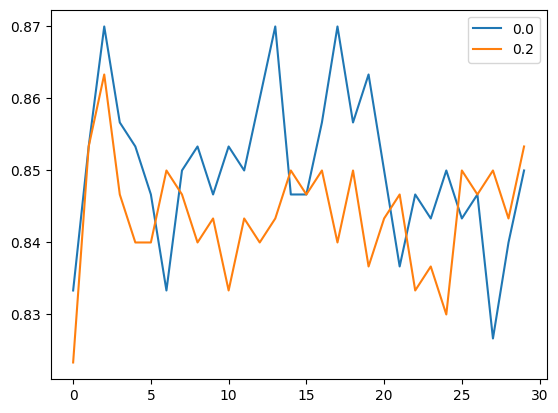

In [59]:
hist = scores_droprate[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores_droprate[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

Honestly, I am still going to choose 0.2 as a droprate to have some regularization in place.

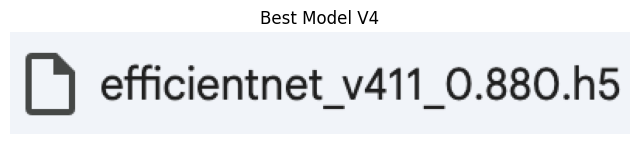

In [60]:
image_path = "./images2/best_model_v4.png"
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V4")
plt.show()

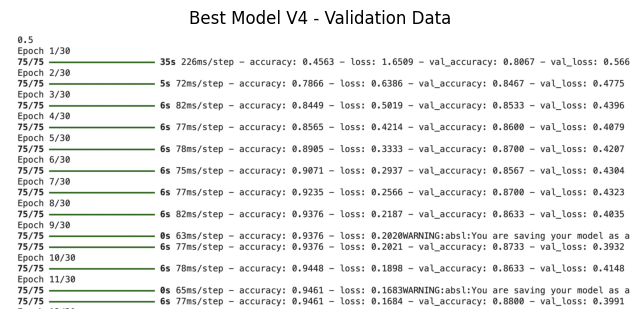

In [61]:
image_path = "./images2/best_model_v4_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V4 - Validation Data")
plt.show()

The best model was for droprate of 0.5, and on the 11th epoch is when it got to that point. Again, I am not using 0.5 as a drop rate since I am basically freezing 50% of our neurons randomly for each iteration. I'd like to be a little less agressive and use 0.2 drop rate.

Let's see if data augmentation can help, too.

## Data Augmentation

In [62]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    vertical_flip=True
    )
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(150,150),
      batch_size=32
      )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(150,150),
      batch_size=32,
      shuffle=False
      )


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [63]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnet_v5{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

Let's first re-train the best model with 50 epochs.

In [65]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model_more_layers_and_drop(learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5173 - loss: 1.4897

75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.5192 - loss: 1.4844 - val_accuracy: 0.8367 - val_loss: 0.5111
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8177 - loss: 0.6077

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8178 - loss: 0.6073 - val_accuracy: 0.8533 - val_loss: 0.4486
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.8486 - loss: 0.4429 - val_accuracy: 0.8333 - val_loss: 0.4763
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9020 - loss: 0.3375 - val_accuracy: 0.8433 - val_loss: 0.4217
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9051 - loss: 0.3045

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9050 - loss: 0.3047 - val_accuracy: 0.8600 - val_loss: 0.4312
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9130 - loss: 0.2604 - val_accuracy: 0.8500 - val_loss: 0.4218
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9299 - loss: 0.2259 - val_accuracy: 0.8467 - val_loss: 0.4512
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9468 - loss: 0.1939 - val_accuracy: 0.8533 - val_loss: 0.4462
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9450 - loss: 0.1784 - val_accuracy: 0.8533 - val_loss: 0.4459
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9596 - loss: 0.1405 - val_accuracy: 0.8467 - val_loss: 0.4487
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9639 - loss: 0.1248 - val_accuracy: 0.8433 - val_loss: 0.4505
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9608 - loss: 0.1310 - val_accuracy: 0.8433 - val_loss:

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9633 - loss: 0.1170 - val_accuracy: 0.8633 - val_loss: 0.4504
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9677 - loss: 0.1124 - val_accuracy: 0.8433 - val_loss: 0.4712
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9768 - loss: 0.0978 - val_accuracy: 0.8433 - val_loss: 0.4835
Epoch 16/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9736 - loss: 0.0920 - val_accuracy: 0.8433 - val_loss: 0.4751
Epoch 17/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9753 - loss: 0.0856 - val_accuracy: 0.8500 - val_loss: 0.4770
Epoch 18/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9802 - loss: 0.0763 - val_accuracy: 0.8367 - val_loss: 0.4902
Epoch 19/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9825 - loss: 0.0730 - val_accuracy: 0.8433 - val_loss: 0.5047
Epoch 20/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9792 - loss: 0.0724 - val_accuracy: 0.8500 - val_l

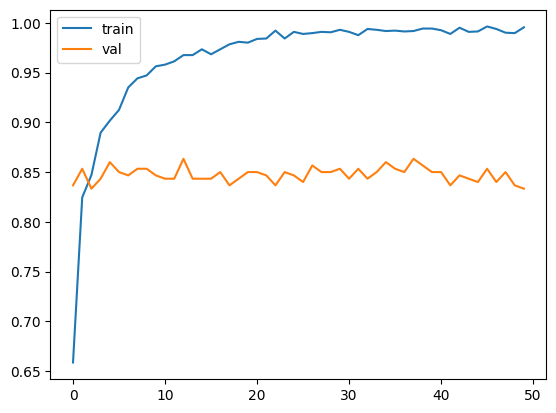

In [66]:
hist = history.history
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')
plt.legend()

Conclusion: applying augmentation to smaller models makes the performance a little worse, so we are not going to use it.

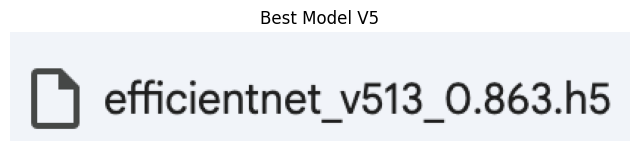

In [67]:
image_path = "./images2/best_model_v5.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V5")
plt.show()

## Training a larger model

In [68]:
def make_model_more_layers_and_drop_large(input_size=150,learning_rate=0.001, size_inner=100, droprate=0.2):
  base_model=EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size,input_size,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(input_size,input_size,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [69]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
    )
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(299,299),
      batch_size=32
      )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(299,299),
      batch_size=32,
      shuffle=False
      )


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [70]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnet_v6{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [71]:
learning_rate = 0.0005
size = 100
droprate = 0.2
input_size=299

model = make_model_more_layers_and_drop_large(input_size=299, learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5006 - loss: 1.6756

75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 886ms/step - accuracy: 0.5027 - loss: 1.6696 - val_accuracy: 0.8233 - val_loss: 0.5428
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8338 - loss: 0.5787

75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 656ms/step - accuracy: 0.8339 - loss: 0.5782 - val_accuracy: 0.8667 - val_loss: 0.3996
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8717 - loss: 0.4362

75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 654ms/step - accuracy: 0.8717 - loss: 0.4358 - val_accuracy: 0.9100 - val_loss: 0.3349
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 667ms/step - accuracy: 0.8998 - loss: 0.3314 - val_accuracy: 0.8733 - val_loss: 0.3573
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 679ms/step - accuracy: 0.9088 - loss: 0.3148 - val_accuracy: 0.8967 - val_loss: 0.3143
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9181 - loss: 0.2558

75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 662ms/step - accuracy: 0.9180 - loss: 0.2560 - val_accuracy: 0.9133 - val_loss: 0.3165
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 652ms/step - accuracy: 0.9173 - loss: 0.2514 - val_accuracy: 0.9100 - val_loss: 0.3047
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 651ms/step - accuracy: 0.9480 - loss: 0.2032 - val_accuracy: 0.8967 - val_loss: 0.3164
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 651ms/step - accuracy: 0.9489 - loss: 0.1768 - val_accuracy: 0.8967 - val_loss: 0.3059
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 650ms/step - accuracy: 0.9507 - loss: 0.1824 - val_accuracy: 0.9033 - val_loss: 0.3094
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 650ms/step - accuracy: 0.9496 - loss: 0.1656 - val_accuracy: 0.9100 - val_loss: 0.2965
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 652ms/step - accuracy: 0.9705 - loss: 0.1265 - val_accuracy: 0.9100 - val_loss: 0.3010
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 653ms/step - accuracy: 0.9669 - loss: 0.1258 - val_accuracy: 0

KeyboardInterrupt: 

I've interrupted the code for training to not run out of the TPU resources I have been provided by Google Colab.

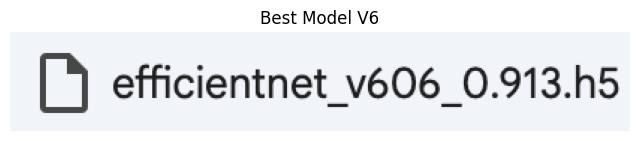

In [72]:
image_path = "./images2/best_model_v6.png"
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V6")
plt.show()

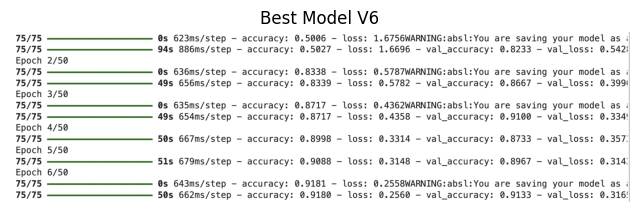

In [73]:
image_path = "./images2/best_model_v6_val_data.png"
image = Image.open(image_path)

# Display the image/
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V6")
plt.show()

We can see that on the 6th epoch for the larger model the highest accuracy has been yielded of 0.913. I did not run all 50 epochs of training since I did not want to run out of TPU. This models seems to overfit, so I'll be using another model, which yielded an accuracy of 0.910.

## Using the model

In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import load_img

In [82]:
model = keras.models.load_model('efficientnet_v603_0.910.h5')

In [83]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory(
    './food-101/test',
      target_size=(299,299),
      batch_size=32,
      shuffle=False
      )

Found 300 images belonging to 10 classes.


In [84]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 673ms/step - accuracy: 0.8545 - loss: 0.5015


[0.4757072925567627, 0.8600000143051147]

The test accuracy of the data is 0.860. It's a bit far from the validation accuracy of 0.91, but let's see how well a model with a lower score will perform.

In [85]:
model2 = keras.models.load_model('efficientnet_v602_0.867.h5')

In [87]:
model2.evaluate(test_ds)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 600ms/step - accuracy: 0.8270 - loss: 0.5896


[0.5525770783424377, 0.8366666436195374]

The test accuracy of the data is 0.836. It's a bit far from the validation accuracy of 0.867, but the performance of the first model was better.


## Applying the model to the image

In [88]:
path = './food-101/test/hamburger/170292.jpg'

In [89]:
img = load_img(path, target_size=(299,299))

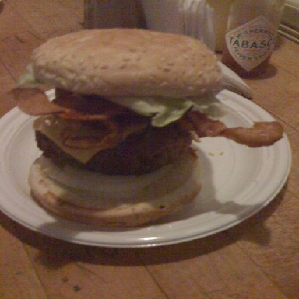

In [90]:
img

In [91]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [92]:
classes = ['chicken_curry',
 'chocolate_cake',
 'fish_and_chips',
 'hamburger',
 'ice_cream',
 'pad_thai',
 'pizza',
 'ramen',
 'sushi',
 'tacos']

In [93]:
prediction = dict(zip(classes,pred[0]))

In [94]:
prediction

{'chicken_curry': np.float32(-1.2163913),
 'chocolate_cake': np.float32(1.7921247),
 'fish_and_chips': np.float32(1.3778944),
 'hamburger': np.float32(4.37665),
 'ice_cream': np.float32(2.4991403),
 'pad_thai': np.float32(-2.3418863),
 'pizza': np.float32(-1.6933304),
 'ramen': np.float32(-3.0775342),
 'sushi': np.float32(0.44076622),
 'tacos': np.float32(-0.29983765)}

So, it looks like the model output hamburger as our prediction, which is right :)

## Export the model to ONNX

In [95]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 61.4 MB/s eta 0:00:00


In [96]:
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: onnx
    Found existing installation: onnx 1.20.0
    Uninstalling onnx-1.20.0:
      Successfully uninstalled onnx-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires pr

In [97]:
# Export to ONNX
onnx_path = "food_classifier_efficientnet_v6.onnx"

import tensorflow as tf
from tensorflow import keras
import tf2onnx
import tf2onnx.convert
import onnx

In [99]:
# 1. Load your Keras model (e.g., from an H5 file)
keras_model = keras.models.load_model('efficientnet_v603_0.910.h5')


In [100]:
# 2. Define input signature - corrected version
input_signature = [tf.TensorSpec(keras_model.input[0].shape, keras_model.input[0].dtype, name="input")]

# 3. Convert to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(keras_model,
                                         input_signature=input_signature,
                                  )

# 4. Save the ONNX model
onnx.save(onnx_model, onnx_path)

print(f"Model converted and saved to {onnx_path}")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7e6420b10540>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model converted and saved to food_classifier_efficientnet_v6.onnx


## Testing the ONNX model

In [101]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.8 MB/s eta 0:00:00


In [102]:
import onnxruntime as ort
import numpy as np
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input

In [103]:
# 1. Load the ONNX model
onnx_session = ort.InferenceSession(onnx_path)

# 2. Check model info
print("ONNX model loaded successfully!")
print(f"Input name: {onnx_session.get_inputs()[0].name}")
print(f"Input shape: {onnx_session.get_inputs()[0].shape}")
print(f"Output name: {onnx_session.get_outputs()[0].name}")
print(f"Output shape: {onnx_session.get_outputs()[0].shape}")

ONNX model loaded successfully!
Input name: input
Input shape: ['unk__1288', 299, 299, 3]
Output name: dense_25
Output shape: ['unk__1289', 10]


In [104]:
# 3. Prepare test data (same preprocessing as your training)
def prepare_image(image_path):
    # Load and resize image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))

    # Preprocess (same as training)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)

    return img.astype(np.float32)

In [105]:
# 4. Test with an image
test_image_path = "./food-101/test/hamburger/170292.jpg"  # Replace with actual path
input_data = prepare_image(test_image_path)

# 5. Run inference
input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

onnx_outputs = onnx_session.run([output_name], {input_name: input_data})
onnx_prediction = onnx_outputs[0]

print(f"ONNX prediction shape: {onnx_prediction.shape}")
print(f"ONNX prediction: {onnx_prediction}")



ONNX prediction shape: (1, 10)
ONNX prediction: [[-1.4091871   1.7687064   1.2159384   4.0974593   2.510992   -2.1179698
  -1.7267574  -3.065944    0.3283205  -0.17808306]]


In [106]:
classes = ['chicken_curry',
 'chocolate_cake',
 'fish_and_chips',
 'hamburger',
 'ice_cream',
 'pad_thai',
 'pizza',
 'ramen',
 'sushi',
 'tacos']

# Also, you need to flatten the ONNX prediction array
prediction_onnx = dict(zip(classes, onnx_prediction[0]))  # Note the [0] to get the first (and only) sample

In [107]:
prediction_onnx

{'chicken_curry': np.float32(-1.4091871),
 'chocolate_cake': np.float32(1.7687064),
 'fish_and_chips': np.float32(1.2159384),
 'hamburger': np.float32(4.0974593),
 'ice_cream': np.float32(2.510992),
 'pad_thai': np.float32(-2.1179698),
 'pizza': np.float32(-1.7267574),
 'ramen': np.float32(-3.065944),
 'sushi': np.float32(0.3283205),
 'tacos': np.float32(-0.17808306)}

In [108]:
# 6. Compare with original Keras model (optional)
keras_prediction = keras_model.predict(input_data)
print(f"Keras prediction: {keras_prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Keras prediction: [[-1.4091882   1.7687141   1.215935    4.0974503   2.5109973  -2.1179686
  -1.7267578  -3.0659397   0.32831872 -0.17808913]]


In [109]:
# Flatten the ONNX prediction array
prediction_keras = dict(zip(classes, keras_prediction[0]))

In [110]:
prediction_keras

{'chicken_curry': np.float32(-1.4091882),
 'chocolate_cake': np.float32(1.7687141),
 'fish_and_chips': np.float32(1.215935),
 'hamburger': np.float32(4.0974503),
 'ice_cream': np.float32(2.5109973),
 'pad_thai': np.float32(-2.1179686),
 'pizza': np.float32(-1.7267578),
 'ramen': np.float32(-3.0659397),
 'sushi': np.float32(0.32831872),
 'tacos': np.float32(-0.17808913)}

In [111]:
# check if predicitons are close
max_value_keras = max(prediction_keras.values())
max_value_onnx = max(prediction_onnx.values())
print(f"Max value keras: {max_value_keras}")
print(f"Max value onnx: {max_value_onnx}")

Max value keras: 4.097450256347656
Max value onnx: 4.097459316253662


In [112]:
# Check if predictions are close
diff = np.abs(max_value_onnx - max_value_keras)
print(f"Max difference: {np.max(diff)}")
print(f"Are predictions close? {np.allclose(max_value_onnx, max_value_keras, atol=1e-5)}")

Max difference: 9.059906005859375e-06
Are predictions close? True


Looks like the scores for the 2 models are not significantly different. both of the models output hamburger as a final prediction, which is correct and cool. We are going to use ONNX model for the training and predicting the food.